# Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pprint import pprint

import lightgbm as lgb
import optuna.integration.lightgbm as opt_lgb
import scikitplot as skplt
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [3]:
%load_ext watermark
%watermark -v -n -m -p numpy,sklearn,lightgbm,pandas,seaborn

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

numpy   : 1.23.5
sklearn : 1.2.0
lightgbm: 3.3.2
pandas  : 1.4.3
seaborn : 0.12.2

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [4]:
# Import cleaned dataset
prices = pd.read_parquet(r'..\data\processed\training_cleaned_engineered.parquet')

Since we'll only be using decision trees (RF, LightGBM), we can simply use numeric categories as these models do not associate numeric data to be ordinal. We also do not need to check of collinearity given the model choice.

In [5]:
## Alternately we can use dummy variables
# prices_ohc = pd.get_dummies(prices.select_dtypes('category'))\
#                 .merge(prices.select_dtypes(exclude='category'), 
#                        left_index=True, 
#                        right_index=True)

for col in prices.select_dtypes('category').columns:
    prices[col] = prices[col].cat.codes

In [6]:
X_train, X_test, y_train, y_test = train_test_split(prices.drop('price', axis=1), 
                                                    prices['price'], 
                                                    test_size= 0.25,
                                                    random_state=42)

In [7]:
# Collect models and test metrics
all_results = []

def regression_metrics(model, 
                       model_name,
                       collect=True):
    """Function to measure and store model metrics for X_test y_test,
        for an updated model the name should have some variation
    """
    model_params = {}
    model_params['model_name'] = model_name
    model_params['model'] = model
    model_params['timestamp'] = str(datetime.datetime.now())
    for dataset_type, scores in zip(['train', 'test'],
                                [(y_train, model.predict(X_train)), 
                                 (y_test, model.predict(X_test))]):        
        model_params[dataset_type] = {}
        model_params[dataset_type]['R2 Score'] = r2_score(scores[0], scores[1])
        model_params[dataset_type]['RMSE'] = np.sqrt(mean_squared_error(scores[0], scores[1]))
        model_params[dataset_type]['MAPE'] = mean_absolute_percentage_error(scores[0], scores[1])
        
    pprint(model_params)
    
    if collect:
        all_results.append(model_params)

In [8]:
def metrics():
    """Function to create a pretty dataframe out of metrics"""
    # Create a model dataframe
    model_df = pd.DataFrame(all_results)
    model_df.columns = pd.MultiIndex.from_product([['Model'], model_df.columns]) # Add column
    
    if model_df.empty:
        return 'No Metrics'
    
    for dataset in ['test', 'train']:
        df = pd.DataFrame(all_results)[dataset].apply(pd.Series)
        df.columns = pd.MultiIndex.from_product([[dataset], df.columns])
        model_df = model_df.merge(df, 
                                  left_index=True, 
                                  right_index=True)
        #display(model_df)
    cm = sns.light_palette("seagreen", 
                           reverse=True, 
                           as_cmap=10)
#     model_df.set_index(('Model','model_name'), inplace=True)
#     model_df.index.rename('Model Name', inplace=True)
    return model_df.drop(['train', 'test'], axis=1, level=1).drop_duplicates(subset=[('Model', 'model_name'), ('Model','timestamp')]).style.background_gradient(cmap=cm)

## Train and Plot a Decision Tree

In [9]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, 
           y_train)

DecisionTreeRegressor()

In [10]:
# Out of bag score will be used as the minimum for the model
regression_metrics(dt_reg, 'Decision Tree')

{'model': DecisionTreeRegressor(),
 'model_name': 'Decision Tree',
 'test': {'MAPE': 0.13552425379829233,
          'R2 Score': 0.7128687904188071,
          'RMSE': 41686.855769051625},
 'timestamp': '2023-03-02 20:37:19.565429',
 'train': {'MAPE': 2.617310864038917e-05,
           'R2 Score': 0.9999980087748153,
           'RMSE': 113.33091920928732}}


In [12]:
# plot_tree(dt_reg, feature_names=['Quality', 'Area'], impurity=False)

## Random Forest Regression

In [13]:
randomf_reg = RandomForestRegressor(random_state=42,
                                      oob_score=True,
                                      n_jobs=-1)
randomf_reg.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=42)

In [14]:
# Out of bag score will be used as the minimum for the model
print(randomf_reg.oob_score_, '\n')
regression_metrics(randomf_reg, 'Random Forest Regression')

0.8863250281647154 

{'model': RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=42),
 'model_name': 'Random Forest Regression',
 'test': {'MAPE': 0.08645636457230998,
          'R2 Score': 0.866963462204083,
          'RMSE': 28375.557731905883},
 'timestamp': '2023-03-02 20:38:14.038386',
 'train': {'MAPE': 0.03668910608412481,
           'R2 Score': 0.984526179698846,
           'RMSE': 9990.494787111083}}


In [15]:
metrics()

In [53]:
# Look at the random forest features to understand what should be tuned
randomf_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [17]:
param_grid = {
    'max_depth': np.arange(20, 200, 50),
    'max_features': ('sqrt', 'log2'),
    'min_samples_leaf': np.arange(3, 8, 2),
    'min_samples_split': np.arange(5, 15, 4),
    'n_estimators': np.arange(100, 1000, 200)
}

rf_grid = GridSearchCV(estimator = randomf_reg,
                       param_grid = param_grid,
                       scoring = 'neg_root_mean_squared_error',
                       cv = 3,
                       n_jobs = -1)

In [18]:
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestRegressor(n_jobs=-1, oob_score=True,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [70, 100], 'min_samples_leaf': [3, 5],
                         'min_samples_split': [4, 6],
                         'n_estimators': [800, 100]},
             scoring='neg_root_mean_squared_error')

In [20]:
rf_grid.best_params_

{'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 900}

<AxesSubplot: title={'center': 'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

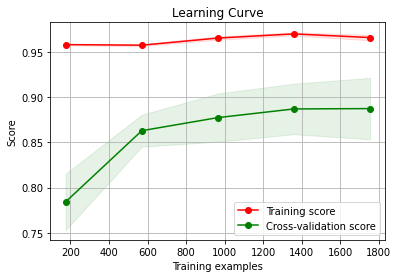

In [56]:
# A plot of the train and test learning curves for a classifier.
skplt.estimators.plot_learning_curve(rf_grid.best_estimator_, 
                                     X_train, 
                                     y_train,
                                     n_jobs=-1)

In [19]:
# Out of bag score will be used as the minimum for the model
print(rf_grid.best_estimator_, '\n')
regression_metrics(rf_grid.best_estimator_, 'Random Forest Regression - Grid Search Tuned')

RandomForestRegressor(max_depth=70, min_samples_leaf=3, min_samples_split=4,
                      n_jobs=-1, oob_score=True, random_state=42) 

{'model': RandomForestRegressor(max_depth=70, min_samples_leaf=3, min_samples_split=4,
                      n_jobs=-1, oob_score=True, random_state=42),
 'model_name': 'Random Forest Regression - Grid Search Tuned',
 'test': {'MAPE': 0.08618557292207135,
          'R2 Score': 0.8659191664255618,
          'RMSE': 28486.70971810993},
 'timestamp': '2023-03-02 20:41:11.324318',
 'train': {'MAPE': 0.04994321571754982,
           'R2 Score': 0.9671337282899479,
           'RMSE': 14560.069354076828}}


In [20]:
metrics()

In [21]:
# Look at the feature importance for the tree model
features_and_scores = []
for name, score in zip(X_train.columns, rf_grid.best_estimator_.feature_importances_):
    features_and_scores.append([name, round(score, 3)])

sorted(features_and_scores, key = lambda x: x[1], reverse=True)[:15]

[['OverallQual', 0.633],
 ['area', 0.139],
 ['TotalBsmtSF', 0.041],
 ['X1stFlrSF', 0.031],
 ['X2ndFlrSF', 0.024],
 ['BsmtFinSF1', 0.021],
 ['LotArea', 0.017],
 ['GarageArea', 0.014],
 ['YearsToSale', 0.012],
 ['GarageCars', 0.011],
 ['KitchenQual', 0.005],
 ['WoodDeckSF', 0.005],
 ['MSZoning', 0.004],
 ['Neighborhood', 0.004],
 ['BsmtQual', 0.004]]

In [22]:
# Tree based estimators will be biased towards continius features
# or higher dimensional features, look at permutation importance
# this is model dependent, based model -> invalid importance
perm_importance = permutation_importance(randomf_reg, X_train, y_train,
                                         n_repeats=30,
                                         random_state=42,
                                         n_jobs=-1)

# Look at the feature importance for the tree model
p_importance = []
for name, score in zip(X_train.columns, perm_importance.importances_mean):
    p_importance.append([name, round(score, 3)])

sorted(p_importance, key = lambda x: x[1], reverse=True)[:15]

[['OverallQual', 0.509],
 ['area', 0.186],
 ['TotalBsmtSF', 0.036],
 ['BsmtFinSF1', 0.025],
 ['X1stFlrSF', 0.023],
 ['YearsToSale', 0.017],
 ['LotArea', 0.016],
 ['X2ndFlrSF', 0.013],
 ['GarageCars', 0.012],
 ['GarageArea', 0.012],
 ['MSZoning', 0.004],
 ['Neighborhood', 0.004],
 ['WoodDeckSF', 0.004],
 ['OpenPorchSF', 0.004],
 ['OverallCond', 0.004]]

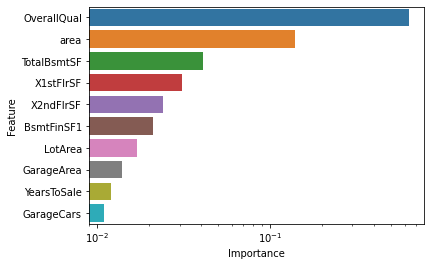

In [27]:
features_df = pd.DataFrame(features_and_scores, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False).head(10)
sns.barplot(data=features_df,
            y='Feature',
            x='Importance',
            orient='h')
plt.xscale('log')

## LightGBM

In [28]:
# Create validation sets
X2_train, X2_validate, y2_train, y2_validate = train_test_split(X_train, 
                                                                y_train, 
                                                                test_size= 0.25,
                                                                random_state=42)

In [29]:
lgb_train = lgb.Dataset(X2_train, y2_train)
validation_set = lgb.Dataset(X2_validate, y2_validate)

In [30]:
# Train a vanilla model
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
}

booster = lgb.train(params,
                    lgb_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2503
[LightGBM] [Info] Number of data points in the train set: 1644, number of used features: 43
[LightGBM] [Info] Start training from score 180104.953163


In [31]:
regression_metrics(booster, 'LightGBM')
metrics()

{'model': <lightgbm.basic.Booster object at 0x000001B422CCE430>,
 'model_name': 'LightGBM',
 'test': {'MAPE': 0.08254212699344546,
          'R2 Score': 0.875114246779076,
          'RMSE': 27492.573084624106},
 'timestamp': '2023-03-02 20:42:29.779579',
 'train': {'MAPE': 0.05295803543264103,
           'R2 Score': 0.9574743359457822,
           'RMSE': 16562.037933623462}}


In [32]:
lgb_train = lgb.Dataset(X2_train, y2_train)
validation_set = lgb.Dataset(X2_validate, y2_validate)

In [56]:
# Integration only tunes the following
# lambda_l1, lambda_l2, num_leaves, feature_fraction, bagging_fraction, bagging_freq and min_child_samples
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
}

# Using Optuna to tune, create a study to tune for final model
tuned_booster = opt_lgb.train(params,
                             lgb_train,
                             valid_sets=[validation_set],
                             early_stopping_rounds=1000,
                             show_progress_bar = True)

In [34]:
print(f'Validation Set Best Score\n: {tuned_booster.best_score} \n')
regression_metrics(tuned_booster, 'LightGBM Optuna Tuned', collect=True)

Validation Set Best Score
: defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('rmse', 24771.51147325579)])}) 

{'model': <lightgbm.basic.Booster object at 0x000001B422D5C070>,
 'model_name': 'LightGBM Optuna Tuned',
 'test': {'MAPE': 0.07597770400002897,
          'R2 Score': 0.8782770612169689,
          'RMSE': 27142.20673013889},
 'timestamp': '2023-03-02 20:44:11.467397',
 'train': {'MAPE': 0.02605187752257108,
           'R2 Score': 0.9759083786209063,
           'RMSE': 12465.831079971773}}


In [35]:
metrics()

In [40]:
tuned_booster.params

{'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': 'rmse',
 'num_leaves': 31,
 'learning_rate': 0.05,
 'feature_fraction': 0.44800000000000006,
 'bagging_fraction': 0.9425027593958745,
 'bagging_freq': 6,
 'verbose': 0,
 'feature_pre_filter': False,
 'lambda_l1': 4.645269379905211,
 'lambda_l2': 3.462023380485085e-07,
 'min_child_samples': 5,
 'num_iterations': 1000,
 'early_stopping_round': 1000}

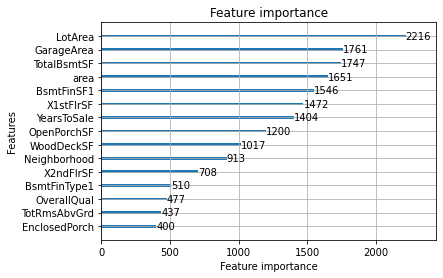

In [41]:
ax = lgb.plot_importance(tuned_booster, max_num_features=15)

In [42]:
joblib.dump(tuned_booster, r"models\lightgbm_tuned.pkl")

['models\\lightgbm_tuned.pkl']

In [43]:
metrics().to_excel(f"models\Regression Models {datetime.datetime.today().strftime('%Y-%m-%d_%H-%M')}.xlsx")

## Analyze Predictions

In [44]:
# Load trained model
final_model = joblib.load(r"models\lightgbm_tuned.pkl")

In [45]:
results = X_test.copy()

results['PredictedPrice'] = final_model.predict(X_test)
results['Price'] = y_test
results['PredictionDelta'] = results['Price']-results['PredictedPrice']

# Bin rates to group by
results['StreetRateBins'] = pd.qcut(results['Price'], 10)

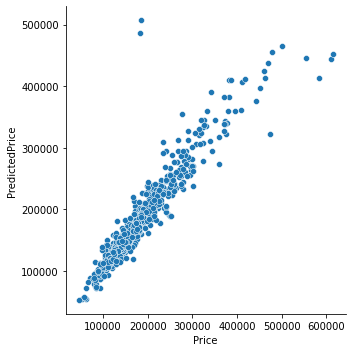

In [51]:
sns.relplot(data=results,
         x='Price',
         y='PredictedPrice')

There are some significant outliers to the predictions themselves as shown above. While the error follows a normal distribution, prices for some houses are predicted to be $300,000 more than what they sold for.

In [52]:
def regression_metrics(x):
    """Returns select scores for the predictions vs actual rates"""
    return pd.Series([format(r2_score(x['Price'], x['PredictedPrice']), '.3f'),
                      np.sqrt(mean_squared_error(x['Price'], x['PredictedPrice'])),
                      mean_absolute_percentage_error(x['Price'], x['PredictedPrice'])],                     
                      index=['R2 Score','RMSE','MAPE'])

In [53]:
results.groupby(by=['StreetRateBins'])[['Price', 'PredictedPrice']].apply(regression_metrics)

,R2 Score,RMSE,MAPE
StreetRateBins,,,
"(44999.999, 108000.0]",-0.062,14406.677864,0.118491
"(108000.0, 125500.0]",-3.835,10922.273609,0.068707
"(125500.0, 138000.0]",-10.414,12391.131545,0.066173
"(138000.0, 149000.0]",-7.566,9222.971964,0.049732
"(149000.0, 165400.0]",-8.176,12615.343088,0.064377
"(165400.0, 180000.0]",-11.837,15148.481355,0.061726
"(180000.0, 200500.0]",-84.078,54513.650377,0.105860
"(200500.0, 227000.0]",-2.741,14514.839594,0.052992
"(227000.0, 276000.0]",-2.971,27752.548319,0.084036


The model seems to struggle for houses that were sold in the 180-200k range.

In [55]:
results.groupby(by=['OverallCond'])[['Price', 'PredictedPrice']].apply(regression_metrics)

,R2 Score,RMSE,MAPE
OverallCond,,,
1,0.436,13486.687716,0.131914
2,-1.309,13676.655724,0.183785
3,0.838,18848.741242,0.103906
4,0.805,24108.071627,0.112045
5,0.856,32553.200192,0.075772
6,0.847,16260.255328,0.071542
7,0.891,14529.033869,0.072144
8,0.802,12581.121475,0.059155
9,0.316,24436.745845,0.091490


The model also struggles the most for lower quality houses, and houses with perfect quality scores. Overall the predictions are still around 25,000 RMSE (without removing the test outliers) and have a R-squared of 0.89 which is a good fit.